# Exponentially-Weighted Means and Covariances

First, we load some basic Python libraries. The less, the better.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Then we define a function for the exponentially-weighted calculations. Note that means and covariances are being calculated together, such that  unnecessary loops and repeats are minimized.

In [2]:
def ew_mean_and_cov(X, lambd):
    """
    Returns (mean_vector, covariance_matrix) using exponentially weighted statistics. The most recent obs is last observations, i.e. X[-1].
    X:  (n_obs x n_assets) of type dataframe
    lambd: decay parameter (0 < lambd < 1).
    """
    X = np.asarray(X)
    n_obs = X.shape[0]
    weights = (1 - lambd) * (lambd ** np.arange(n_obs)[::-1])
    weights = weights / weights.sum()   # This makes the weights sum up to 1 in finite samples.
                                        # Theoretically, weights only converge to 1 if sample size converges to infinity.
                                        # Depending on what you do with the functions result, this methodological difference can become relevant.
    mean_ew = np.sum(weights[:, None] * X, axis=0)
    X_centered = X - mean_ew
    cov_ew = (X_centered * weights[:, None]).T @ X_centered
    return mean_ew, cov_ew

Let's load some data in a pandas dataframe object.

In [3]:
returns = pd.read_csv("data.csv", index_col=0, parse_dates=True)

Check how many time series there are in this dataset.

In [4]:
n_assets = returns.shape[1]
print(n_assets)

30


And let's also see how many observations we have.

In [5]:
n_obs = returns.shape[0]
print(n_obs)

487


Exponential weighing schemes require a parameter which determines the decay of the exponential weights. This parameter is either expressed as a half-life, or then as a more abstract Lambda value. 0.94 is a rather popular value, for historical reasons that we maybe cover in a future version of this notebook.

In [6]:
lambd = 0.94

The reason for this rather odd name is that "lambda" is a an expression used for very different purposes in Python.

Anyway, let us now pass our input data and parameter value to the above function, and let the function do its work.

In [7]:
mean_vector, cov_matrix = ew_mean_and_cov(returns, lambd)

The results are a vector of mean returns

In [8]:
print(mean_vector.shape)

(30,)


and a matrix of covariances.

In [9]:
print(cov_matrix.shape)

(30, 30)


The code below formats the function results such that they can be visualized in three bar plots.

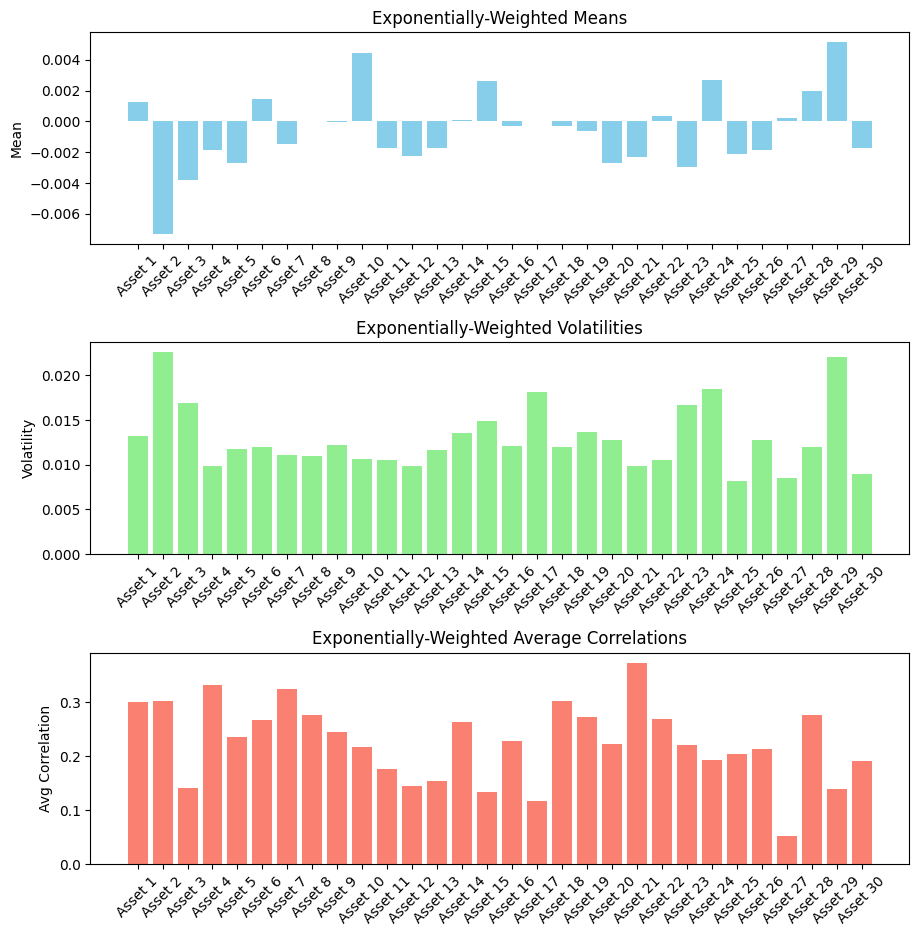

In [10]:
# Asset names setup
asset_names = [f'Asset {i+1}' for i in range(n_assets)]

# Calculate volatilities (standard deviations)
volatilities = np.sqrt(np.diag(cov_matrix))

# Calculate correlations matrix
stddev = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / np.outer(stddev, stddev)

# Calculate average correlation for each asset with all others
avg_correlations = (np.sum(corr_matrix, axis=1) - 1) / (n_assets - 1)  # exclude self-correlation

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# Mean returns bar plot
axs[0].bar(asset_names, mean_vector, color='skyblue')
axs[0].set_title('Exponentially-Weighted Means')
axs[0].set_ylabel('Mean')
axs[0].tick_params(axis='x', rotation=45)

# Volatilities bar plot
axs[1].bar(asset_names, volatilities, color='lightgreen')
axs[1].set_title('Exponentially-Weighted Volatilities')
axs[1].set_ylabel('Volatility')
axs[1].tick_params(axis='x', rotation=45)

# Average correlations bar plot
axs[2].bar(asset_names, avg_correlations, color='salmon')
axs[2].set_title('Exponentially-Weighted Average Correlations')
axs[2].set_ylabel('Avg Correlation')
axs[2].tick_params(axis='x', rotation=45)

plt.show()


A possible use case for these results is traditional mean-variance optimization. Maybe we illustrate this at one point in this notebook.